In [2]:
# importing necessary libraries and packages
import pandas as pd
import os
import numpy as np
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#  Load your dataset from an Excel file
xlsx_file_path = '/content/drive/MyDrive/Colab Notebooks/Dzongkha Bi-LSTM/Dataset20k.xlsx'

# Read the XLSX file
data = pd.read_excel(xlsx_file_path, header=None)

# Display the first few rows of the DataFrame
data.head()


,0
0,ང་ སྡོད་ ས་ ནཱ་ ལུ་ ཨིན །
1,བྱི་ལི་ འདི་ # ཡིད་ཁར་འོང་ཏོག་ཏོ་ འདུག །
2,བྱི་ལི་ འདི་ མ་ ཤི་ བས །
3,བྱི་ལི་ འདི་ ཉལ་ ནུག །
4,རྐང་ཁྲི་ འདི་ ཆག་ ནུག །


In [5]:
!nvidia-smi

Thu Oct 26 09:55:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
data.shape

(20000, 1)

In [7]:
#to select all rows (denoted by :) and the first column (denoted by 0).
# iloc is a method in pandas used to select rows and columns by integer-based indexing.
text_data = data.iloc[:, 0].astype(str)

In [8]:
text_data

0                                ང་ སྡོད་ ས་ ནཱ་ ལུ་ ཨིན །
1                 བྱི་ལི་ འདི་ # ཡིད་ཁར་འོང་ཏོག་ཏོ་ འདུག །
2                                 བྱི་ལི་ འདི་ མ་ ཤི་ བས །
3                                   བྱི་ལི་ འདི་ ཉལ་ ནུག །
4                                  རྐང་ཁྲི་ འདི་ ཆག་ ནུག །
                               ...                        
19995    རྡོ་རྗེ་ གིས་ # ཐག་ རིང་ སར་ ཨིནམ་ ལས # ང་བཅས་...
19996    རྡོ་རྗེ་ འདི་ # བི་ཡར་ འཐུང་ པར་ # ཆུང་ཀུ་ ར་ ...
19997     རྡོ་རྗེ་ གིས་ # ག་ཅི་ ཅིག་ སླབ་ ནི་ # འབད་ དེས །
19998    རྡོ་རྗེ་ འདི་ # ཐོག་ཁ་ ལུ་ # ཁོ་རའི་ ཉལ་ཁང་ ནང...
19999    རྡོ་རྗེ་ འདི་ # གསལ་བཤད་ བཟོ་ ནིའི་ ནང་ # སྦྱང...
Name: 0, Length: 20000, dtype: object

Data Preprocessing

In [9]:
# Removing Unwanted Characters and symbols
text_data = text_data.apply(lambda x: x.replace('#', ''))
text_data = text_data.apply(lambda x: x.replace('།', ''))
text_data = text_data.apply(lambda x: x.replace('?', ''))
text_data = text_data.apply(lambda x: re.sub(r'[a-zA-Z0-9]', '', x))



In [10]:
text_data = text_data.apply(lambda x: x.replace(' ', '$'))
text_data = text_data.apply(lambda x: x.replace('་$', ' '))
text_data = text_data.apply(lambda x: x.replace(' $', ' '))
text_data = text_data.apply(lambda x: x.replace('$', ''))



In [11]:
text_data.head(20)

0                                   ང སྡོད ས ནཱ ལུ ཨིན
1                    བྱི་ལི འདི ཡིད་ཁར་འོང་ཏོག་ཏོ འདུག
2                                   བྱི་ལི འདི མ ཤི བས
3                                    བྱི་ལི འདི ཉལ ནུག
4                                   རྐང་ཁྲི འདི ཆག ནུག
5     རྒྱབ་སྐྱོར གྱི སྐད རྐྱབ ནི འདི མཚམས་འཇོག འབད ནུག
6                                གདམ་ཁ འདི ཁྱོད ལུ ཡོད
7                                 ང ལཱ འབད ས ནཱ ལུ ཨིན
8                 དེ་འབདཝ་ལས ང གིས བརྒྱུད་འཕྲིན བཏང ཡི
9                              དེ་འབདཝ་ལས ང གིས འབད ཡི
10                              དེ་འབདཝ་ལས ང མི ཁོམ པས
11                             དེ་འབདཝ་ལས ང ནཱ སྡོད ཡི
12                            དེ་འབདཝ་ལས ང འཕྱིས སོ ཡི
13                         དེ་འབདཝ་ལས རྡོ་རྗེ ཡར སོ ཡི
14                       དེ་འབདཝ་ལས རྡོ་རྗེ གིས བཞག ཡི
15                         ནཱི ཁྱོད ཀྱི བསམ་འཆར ཨིན པས
16                           རྒྱང་མཐོང མེདཔ ཤོར སོ ནུག
17                         ཨ་ལུ ཁུ་སིམ་སི སྦེ སྡོད ནུག
18        

Tokenizing the text

In [12]:
#Tokenizer object, uses it to tokenize the text_data, and creates a vocabulary of unique words with integer IDs.
#oov_token='<oov>' is an optional parameter which is used when the tokenizer encounters a word that it has not seen during training,
#it will replace that word with "<oov>" to handle unknown words.
tokenizer = Tokenizer(oov_token='<oov>') # tokenizer allows to represent text data as numerical values
tokenizer.fit_on_texts(text_data) #with "fit_on_text" method tokenized each sentence in the text_data
# calculates the total number of unique words in the vocabulary.
#"word_index" refers to a data structure or dictionary that maps words (or tokens) to unique integer IDs.
# like this; {'car': 1, 'prison': 2, 'him': 3, 'welcome': 4}
total_words = len(tokenizer.word_index) + 1

print("Total number of unique words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])



Total number of unique words:  7816
Word: ID
------------
<oov>:  1


In [13]:
# To generate input sequences for a text generation task using N-grams
# N-gram Model captures the statistical relationships
input_sequences = [] #list used to store sequence of tokens(input data)
for line in text_data:
    token_list = tokenizer.texts_to_sequences([line])[0] #converts the text into a list of tokens of integer IDs


    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


#These sequences can be used as input data for training a next word prediction model.
print("Total input sequences: ", len(input_sequences))


Total input sequences:  115351


In [14]:
input_sequences[2]

[2, 37, 136, 71]

In [15]:
input_sequences

[[2, 37],
 [2, 37, 136],
 [2, 37, 136, 71],
 [2, 37, 136, 71, 5],
 [2, 37, 136, 71, 5, 7],
 [266, 3],
 [266, 3, 1531],
 [266, 3, 1531, 35],
 [266, 3],
 [266, 3, 20],
 [266, 3, 20, 143],
 [266, 3, 20, 143, 80],
 [266, 3],
 [266, 3, 225],
 [266, 3, 225, 21],
 [566, 3],
 [566, 3, 718],
 [566, 3, 718, 21],
 [421, 51],
 [421, 51, 270],
 [421, 51, 270, 49],
 [421, 51, 270, 49, 13],
 [421, 51, 270, 49, 13, 3],
 [421, 51, 270, 49, 13, 3, 680],
 [421, 51, 270, 49, 13, 3, 680, 10],
 [421, 51, 270, 49, 13, 3, 680, 10, 21],
 [172, 3],
 [172, 3, 6],
 [172, 3, 6, 5],
 [172, 3, 6, 5, 25],
 [2, 65],
 [2, 65, 10],
 [2, 65, 10, 136],
 [2, 65, 10, 136, 71],
 [2, 65, 10, 136, 71, 5],
 [2, 65, 10, 136, 71, 5, 7],
 [645, 2],
 [645, 2, 4],
 [645, 2, 4, 174],
 [645, 2, 4, 174, 116],
 [645, 2, 4, 174, 116, 8],
 [645, 2],
 [645, 2, 4],
 [645, 2, 4, 10],
 [645, 2, 4, 10, 8],
 [645, 2],
 [645, 2, 9],
 [645, 2, 9, 1749],
 [645, 2, 9, 1749, 26],
 [645, 2],
 [645, 2, 71],
 [645, 2, 71, 37],
 [645, 2, 71, 37, 8],
 [6

In [16]:
#finds the maximum sequence length among the input sequences
#and padding the sequences to that maximum length using the pad_sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')) #pre means zero will be addded to the beginning of each sequence
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   2,  37, 136], dtype=int32)

In [17]:
max_sequence_len

22

Split data into features and labels


In [18]:
# create features/ input (xs) and label (ys)
#xs contains all columns except the last one.
#labels contains only the last token in each sequence and these words that the model will try to predict
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
#tf.keras.utils.to_categorical is used to convert these integer labels into one-hot encoded vectors
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


print(xs[5])
print(labels[5])
print(ys[5][5])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 266]
3
0.0


Create the Model

In [19]:
# model = Sequential()
# finally, the size of the input dimensions will be fed in, and this is the length of the longest sequence minus 1.
# We subtract one because we cropped off the last word of each sequence to get the label.
# It takes total_words as the input dimension, 100 as the output dimension (the size of the word embeddings),
# model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))#The embedding layer is used to convert integer-encoded words into dense vectors of fixed size.
# model.add(Bidirectional(LSTM(100)))
# model.add(Dense(total_words, activation='softmax'))
# adam = Adam(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# #And we specified epochs number, One Epoch is when an entire dataset is passed forward and backward
# #through the neural network only once.
# batch_size = 64
# epochs = 150
# history = model.fit(xs, ys, epochs=epochs, batch_size=batch_size, verbose=1)
# print(model.summary())
# print(model)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))  # Regularization using dropout
model.add(Dense(total_words, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model with early stopping
batch_size = 64
epochs = 200
# Early stopping  is used to prevent overfitting and restore the best weights.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(xs, ys, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/200
1803/1803 [==============================] - 45s 20ms/step - loss: 5.6577 - accuracy: 0.1039
Epoch 2/200
1803/1803 [==============================] - 25s 14ms/step - loss: 4.9152 - accuracy: 0.1863
Epoch 3/200
1803/1803 [==============================] - 22s 12ms/step - loss: 4.5614 - accuracy: 0.2250
Epoch 4/200
1803/1803 [==============================] - 23s 13ms/step - loss: 4.3134 - accuracy: 0.2490
Epoch 5/200
1803/1803 [==============================] - 21s 12ms/step - loss: 4.1232 - accuracy: 0.2671
Epoch 6/200
1803/1803 [==============================] - 24s 13ms/step - loss: 3.9621 - accuracy: 0.2820
Epoch 7/200
1803/1803 [==============================] - 23s 13ms/step - loss: 3.8233 - accuracy: 0.2946
Epoch 8/200
1803/1803 [==============================] - 22s 12ms/step - loss: 3.6958 - accuracy: 0.3072
Epoch 9/200
1803/1803 [==============================] - 23s 13ms/step - loss: 3.5841 - accuracy: 0.3185
Epoch 10/200
1803/1803 [==============================]

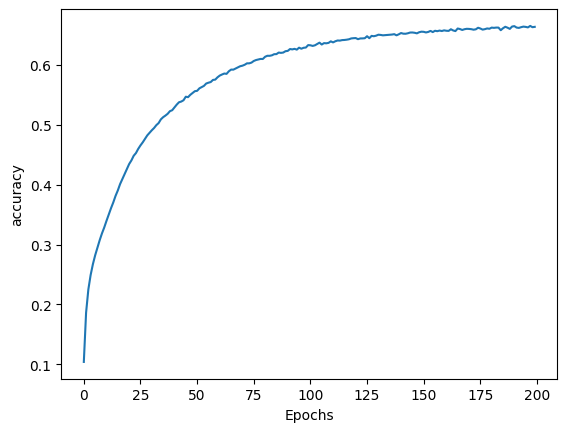

In [ ]:
# Plotting Model Accuracy and Loss
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

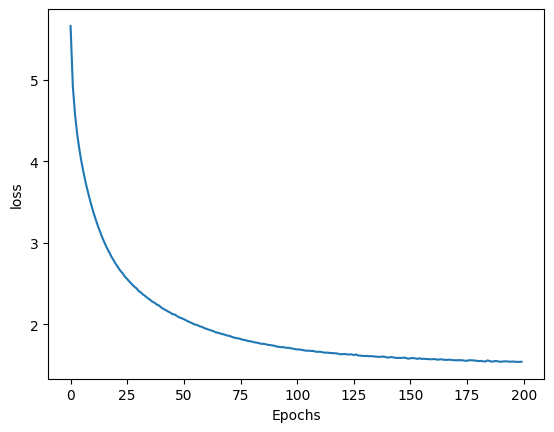

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
#Predicting the Next Word of the Title
seed_text = input("Enter a seed_text: ")

next_words = int(input("Enter the number of next words to generate: "))


for _ in range(next_words):
  # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted_probs = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
    predicted_index = np.argmax(predicted_probs)
# Map the index back to the word using the tokenizer
    predicted_word = None

    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            predicted_word = word
            break

    if predicted_word:
        seed_text += " " + predicted_word

print(seed_text)

In [ ]:
seed_text = input("Enter a seed_text: ")

next_words = 10  # Predict the top 10 next words

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted_probs = model.predict(token_list, verbose=0)
    # Get the indices of the top 10 predicted words
    top_indices = np.argpartition(predicted_probs[0], -10)[-10:]
    # Map the indices back to the words using the tokenizer
    predicted_words = [word for word, index in tokenizer.word_index.items() if index in top_indices]

    print(f"Top 10 predicted words: {predicted_words}")

    user_choice = int(input("Choose one word by entering its index (0-9) as the next word: "))

    # Check if the user choice is valid
    if user_choice < 0 or user_choice >= 10:
        print("Invalid choice. Please choose a valid index.")
        continue

    # Use the user's choice as the next word
    chosen_word = predicted_words[user_choice]
    seed_text += " " + chosen_word

print(seed_text)

In [ ]:
import pickle
model.save('bilstm.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)